In [661]:
import ray.tune
from pathlib import Path
from dataclasses import dataclass, field
from functools import lru_cache
import pandas as pd
from typing import List, Tuple
from functools import partial
import seaborn as sns
import re

In [2]:
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

In [3]:
from etr_fr_expes import metric

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ledoyen202/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
EXPE_DIR = Path("../../experimentations/").resolve()
ICL_EXPE_DIR = EXPE_DIR / "icl_experimentations"

In [10]:
MBARTHEZ, MBART, MISTRAL, LLAMA3 = "mbarthez", "mbart", "mistral", "llama3"
MISTRAL_INSTRUCT, LLAMA_INSTRUCT = "mistral-7b", "llama3-8b"

DEEPSEEK = "deepseekr1"
LORA, MTLLORA = "lora", "mtllora"
ZERO_SHOT = "zero_shot"
COT = "cot"
RAG = "rag"
ETR_FR, ORANGESUM, WIKILARGE, ETR_FR_ORANGESUM, ETR_FR_WIKILARGE, ALL = "etrfr", "orangesum", "wikilarge", "etrfr+orangesum", "etrfr+wikilarge", "etrfr+orangesum+wikilarge"

In [11]:
ETRMetrics = metric.ETRMetrics("fr")

In [12]:
@dataclass
class Expe:
    model: str
    method: str
    task: str
    train_tasks: str
    metric: str
    mode: str
    adapter_name: str
    model_name: str = None
    split: str = "eval"
    expe_dir: str = EXPE_DIR
    step: str = "hp_search"
    _expe_analysis = None
    
    
    @property
    def base_columns(self):
        return [
            # "expe",
            "trial_id",
            "model", 
            "method", 
            "task", 
            "train_tasks", 
            # "metric",
        ]
    
    @property
    def selection_metric(self):
        return f"{self.split}_{self.metric}"
    
    @property
    def expe_name(self):
        return f"{self.model}.{self.method}.{self.train_tasks}"
    
    @property
    def expe_analysis(self):
        step = f"_{self.step}" if self.step else ""
        hp_search_dir = self.expe_dir / self.expe_name / "results" / f"{self.expe_name}{step}"
        if self._expe_analysis is None:
            self._expe_analysis = ray.tune.ExperimentAnalysis(hp_search_dir)
        return self._expe_analysis
    
    @property
    def dfs(self):
        return self.expe_analysis.trial_dataframes

    @property
    def dataframe(self):
        dfs = self.dfs
        res = (pd.concat(dfs, ignore_index=True)
            .reset_index(level=0)
            .assign(
                expe=self.expe_name, 
                model=self.model_name or self.model, 
                metric=self.metric,
                method=self.method,
                task=self.task,
                train_tasks=self.train_tasks,
            )
            .sort_values(by=f"{self.split}_{self.metric}", ascending=self.mode == "min")
            .rename(columns=lambda x: x.replace(self.adapter_name, 'adapter'))
        )
        res = res.set_index(self.base_columns)
        return res
    
    def metric_columns(self, _type="test"):
        return self.dataframe.filter(
            regex=f"{_type}_{self.task}_(?!texts)"
        ).columns
        
    def text_columns(self, _type="test"):
        return self.dataframe.filter(
            regex=f"{_type}.*texts"
        ).columns
        
    @property
    def test_metric_df(self):
        return self.dataframe[self.metric_columns(_type="test")]
    
    @property
    def eval_metric_df(self):
        return self.dataframe[self.metric_columns(_type="eval")]
    
    @property
    def best_model(self):
        return self.dataframe.iloc[0]
    
    def get_texts_df(self, row_idx, _type="test"):
        row_df = self.dataframe.iloc[row_idx].filter(regex=f"{_type}.*texts").to_frame().T
        row_df = row_df.explode(list(row_df.columns)).reset_index(drop=True).stack().to_frame()
        return row_df
    
    @property
    def best_trial(self):
        return self.expe_analysis.get_best_trial(metric=self.metric, mode=self.mode, scope="all")
    
@dataclass
class RAGExpe(Expe):
    
    @property
    def dfs(self):
        return [self.expe_analysis.dataframe()]
    
    def get_best_df(self, df):
        best_idx = df[self.selection_metric].idxmax()
        config_columns = list(df.filter(regex="icl_config").columns)
        best_config = df.loc[best_idx, config_columns]
        
        def is_same_config(row):
            return all((a == b) or (pd.isna(a) and pd.isna(b)) for a, b in zip(row[config_columns], best_config))

        return df[df.apply(is_same_config, axis=1)]
        
    @property
    def dataframe(self):
        res = super().dataframe
        res = self.get_best_df(res)
        return res
    
    
ETRFrExpe = partial(Expe, metric="etr_fr_srb", mode="max", task="etr_fr", adapter_name="lora_etr_fr")
RAGETRFrExpe = partial(RAGExpe, metric="etr_fr_srb", mode="max", task="etr_fr", adapter_name="lora_etr_fr")

OrangesumExpe = partial(Expe, metric="orangesum_rougeL", mode="max", task="orangesum", adapter_name="lora_orangesum")
WikilargeExpe = partial(Expe, metric="wikilarge_fr_sari", mode="max", task="wikilarge_fr")

In [652]:
@dataclass
class Analysis:
    expes: List['Expe']
    metrics: List[str] = field(default_factory=lambda: [
        "rouge1",
        "rouge2",
        "rougeL",
        "sari",
        "bertscore_f1",
        "srb",
        "compression_ratio",
        "novelty",
        # "kmre",
        # "lix"
    ])

    model_order: List[str] = field(default_factory=lambda :[
        MISTRAL_INSTRUCT, 
        LLAMA_INSTRUCT,
        MBARTHEZ,  
        MISTRAL,
        LLAMA3,
    ])
    tasks_order: List[Tuple[str, str]] = field(default_factory=lambda :[
        (ZERO_SHOT, ETR_FR),
        (COT, ETR_FR),
        (RAG, ETR_FR),
        (RAG, ETR_FR_ORANGESUM),
        (RAG, ETR_FR_WIKILARGE),
        (RAG, ALL),
        
        
        (LORA, ETR_FR),
        (MTLLORA, ETR_FR_ORANGESUM),
        (MTLLORA, ETR_FR_WIKILARGE),
        (MTLLORA, ALL),
        
    ])
        

    def _sort_df_by_model_and_tasks(self, df):
        model_map = {k: i for i, k in enumerate(self.model_order)}
        tasks_map = {k: i for i, k in enumerate(self.tasks_order)}

        index_df = pd.DataFrame(df.index.tolist(), columns=['model', 'adapter', 'tasks'])

        index_df['model_order'] = index_df['model'].map(model_map)
        index_df['tasks_tuple'] = list(zip(index_df['adapter'], index_df['tasks']))
        index_df['tasks_order'] = index_df['tasks_tuple'].map(tasks_map)

        sorted_index = pd.MultiIndex.from_frame(
            index_df.sort_values(['model_order', 'tasks_order']).drop(columns=['model_order', 'tasks_order', 'tasks_tuple'])
        )

        return df.reindex(sorted_index)

    def _standardize_column_multiindex(self, df, groups=None, separator="_"):
        if groups is None:
            groups = []

        groups = sorted(groups, key=len, reverse=True)

        new_cols = []
        for metric, stat in df.columns:
            matched_group = "other"
            short_name = metric

            for group in groups:
                if metric.startswith(group + separator):
                    matched_group = group
                    short_name = metric[len(group) + 1:]
                    break

            new_cols.append((matched_group, short_name, stat))

        df.columns = pd.MultiIndex.from_tuples(new_cols, names=['group', 'metric', 'stat'])
        return df

    def _format_mean_std_with_bold(self, df: pd.DataFrame, global_max_idx) -> pd.DataFrame:
        """
        Format mean ± std as LaTeX, and bold the best (max) mean per (group, metric).
        """
        # Ensure it's a MultiIndex with a 'stat' level
        if 'stat' not in df.columns.names:
            raise ValueError("Expected MultiIndex columns with 'stat' level")

        mean = df.xs('mean', level='stat', axis=1)
        std = df.xs('std', level='stat', axis=1)

        # Determine the max mean index per column
        max_idx = mean.idxmax()

        # Build formatted DataFrame
        formatted = pd.DataFrame(index=mean.index, columns=mean.columns)

        for col in mean.columns:
            for idx in mean.index:
                m = mean.at[idx, col]
                s = std.at[idx, col]

                bf = idx == global_max_idx[col]
                underl = idx == max_idx[col]

                # if bf and underl:
                #     formatted.at[idx, col] = f"$\\underline{{\\mathbf{{{m:.2f}}}}}_{{\\pm{s:.2f}}}$"
                if bf:
                    formatted.at[idx, col] = f"$\\mathbf{{{m:.2f}}}_{{\\pm{s:.2f}}}$"
                elif underl:
                    formatted.at[idx, col] = f"$\\underline{{{m:.2f}}}_{{\\pm{s:.2f}}}$"
                else:
                    formatted.at[idx, col] = f"${m:.2f}_{{\\pm{s:.2f}}}$"
        return formatted

    def reorder_metrics(self, df: pd.DataFrame) -> pd.DataFrame:
        """Reorders and filters MultiIndex columns by desired metrics. Supports 2 or 3 levels."""
        desired_order = self.metrics
        order_map = {metric: i for i, metric in enumerate(desired_order)}

        if isinstance(df.columns, pd.MultiIndex):
            num_levels = df.columns.nlevels

            if num_levels == 3:
                filtered_columns = [col for col in df.columns if col[1] in order_map]
                sorted_columns = sorted(filtered_columns, key=lambda col: (
                    col[0], order_map[col[1]], col[2]
                ))
            elif num_levels == 2:
                filtered_columns = [col for col in df.columns if col[1] in order_map]
                sorted_columns = sorted(filtered_columns, key=lambda col: (
                    col[0], order_map[col[1]]
                ))
            else:
                raise ValueError("Unsupported column MultiIndex depth.")

            return df[sorted_columns]

        else:
            # Not a MultiIndex – optionally filter if plain column names match metrics
            filtered_columns = [col for col in df.columns if col in order_map]
            sorted_columns = sorted(filtered_columns, key=lambda col: order_map[col])
            return df[sorted_columns]
        
    def set_task_level(self, df):
        new_tuples = []
        for model, adapter, task_str in df.index:
            task_set = set(task_str.split('+'))
            has_etrfr = 'etrfr' in task_set
            has_orangesum = 'orangesum' in task_set
            has_wikilarge = 'wikilarge' in task_set
            new_tuples.append((model, adapter, has_etrfr, has_orangesum, has_wikilarge))

        # Create MultiIndex
        new_index = pd.MultiIndex.from_tuples(
            new_tuples,
            names=['model', 'adapter', 'etrfr', 'orangesum', 'wikilarge']
        )
        df.index = new_index
        return df
    
    @property
    def dataframe(self):
        dfs = [expe.dataframe for expe in self.expes]
        return pd.concat(dfs)

    def best_models(self, _type=None, texts=False):
        series = [expe.best_model for expe in self.expes]
        res = pd.DataFrame(series)

        return_metrics = _type in ["test", "eval"]
        if not texts and return_metrics:
            res = res.filter(regex=f"{_type}.*({'|'.join(self.metrics)})")
        elif return_metrics:
            cols = self.expes[0].text_columns(_type=_type)
            res = res[cols]
        
        
        res = res.droplevel([0, 3])
        
        res.columns = pd.MultiIndex.from_tuples(
            [(col, "max") for col in res.columns]
        )
        

        return res

    def mean_models(self, _type="test", texts=False):
        res = self.dataframe

        return_metrics = _type in ["test", "eval"]
        if not texts and return_metrics:
            res = res.filter(regex=f"{_type}.*({'|'.join(self.metrics)})")
        elif return_metrics:
            cols = self.expes[0].text_columns(_type=_type)
            res = res[cols]

        res = (res
               .groupby(["model", "method", "train_tasks"])
               .agg(['mean', 'std'])
               .round(2)
        )

        res = self._sort_df_by_model_and_tasks(res)
        res = self._standardize_column_multiindex(res, groups=["test_etr_fr_politic", "test_etr_fr"])
        
        global_max_idx = res.xs('mean', level='stat', axis=1).idxmax()
        res = res.groupby(level="model", sort=False).apply(lambda x: self._format_mean_std_with_bold(x, global_max_idx))
        res = self.reorder_metrics(res)
        res = res.droplevel(0)
        # res = self.set_task_level(res)

        return res

    @property
    def test_metrics(self):
        df = self.best_models(_type="test")
        df = self._standardize_column_multiindex(
            df, 
            ["test_etr_fr", "test_etr_fr_politic"]
        )
        df = df.droplevel(2, axis=1)
        df = self._sort_df_by_model_and_tasks(df)
        df = self.reorder_metrics(df)
        # df = self.process_for_latex(df)
        return df

    @property
    def eval_metrics(self):
        return self.best_models(_type="eval")

    @property
    def test_texts(self):
        return self.best_models(_type="test", texts=True)
    
    def process_for_latex(self, df):
        df = df.copy()
        df = df.rename(index={'zero_shot': 'zeroshot', 'cot': "COT"})
        df.index = pd.MultiIndex.from_tuples(
            # [(f'$\\text{{\\{model}}}_\\text{{\\{adapter}}}$', f"{",".join([t[0].upper() for t in task.split('+')])}") for model, adapter, task in res_df.index],
            [
                (f'\\{model}', f'\\{adapter}', f"{",".join([t[0].upper() for t in task.split('+')])}") 
                for model, adapter, task in df.index
            ],
            # names=("Model+Method", "$\mathcal{D}$")
        )
        df.columns.names = tuple(None for _ in df.columns.names)
        
        latex_metric_names = {
            'rouge1': r'\RI',
            'rouge2': r'\RII',
            'rougeL': r'\RL',
            'sari': r'\sari',
            'bertscore_f1': r'\bertf',
            'srb': r'\SRB',
            'compression_ratio': r'\compratio',
            'novelty': r'\novelty'
        }

        # Replace second level with LaTeX equivalents
        df.columns = pd.MultiIndex.from_tuples(
            [(lvl0, latex_metric_names.get(lvl1, lvl1)) for lvl0, lvl1 in df.columns]
        )
        
        
        
        return df
    
    def to_latex(self, df, split="test_etr_fr"):
        df = self.process_for_latex(df)
        df = (df
            .xs(split, axis=1)
            # .rename_axis(None, axis=1)
            # .rename_axis([None, None, None], axis=0)
        )
        
        def get_column_format(df):
            index = "l"*len(df.index.names)
            cols = "c"*len(df.columns)
            return f"{index}{cols}"
        
        res = (df.style
            .map_index(
                lambda v: "rotatebox:{90}--rwrap;", axis="index", level=0
            )  
            # .format_index(formatter=None, escape="latex-math", axis=1)
            # .format_index(formatter=None, escape="latex-math", axis=0)
            .format_index("\\textbf{{{}}}", escape=None, axis=1)
            .to_latex(
                environment="table*",
                caption="Styled LaTeX Table",
                hrules=True,
                column_format=get_column_format(df),
                position_float="centering",
                multirow_align="c", 
                multicol_align="c",
                clines="skip-last;data",
            )
        )
        return res
    
    def get_text_df(self, test_set):
        def get_idx_or_first(group):
            if group.notna().any():
                return group.idxmax()
            else:
                return group.index[0]

        df = self.dataframe
        idx = df.groupby(
            level=["model", "method", "task", "train_tasks"]
        )["eval_etr_fr_srb"].apply(get_idx_or_first)

        df = df.loc[idx]

        res = pd.DataFrame({
            **{"test_set": test_set},
            **{f"{col}": df.iloc[0].loc[f"{test_set}_texts/{col}"] for col in ("inputs", "labels")},
        })
        gens = df[f"{test_set}_texts/predictions"].to_frame().T.droplevel(["task", "trial_id"], axis=1)
        gens = gens.explode(gens.columns.to_list()).reset_index(drop=True)
        res = pd.concat([res, gens], axis=1)
        return res


In [653]:
def get_rag_expes():
    models = [
        ("mistral-7b", "mistVIIinst"), 
        ("llama3-8b", "llamaVIIIinst")
    ]
    
    methods_tasks = [
        (ZERO_SHOT, [ETR_FR]),
        (COT, [ETR_FR]),
        (RAG, [ETR_FR, ETR_FR_ORANGESUM, ETR_FR_WIKILARGE, ALL])
    ]

    return [
        RAGETRFrExpe(model=model, model_name=model_name, method=method, train_tasks=task, step="", expe_dir=ICL_EXPE_DIR)
        for (model, model_name) in models
        for method, task_list in methods_tasks
        for task in task_list if method == "rag" or task == ETR_FR
    ]

def get_mtl_expes():
    models = [
        # (MBARTHEZ, None), 
        (LLAMA3, "llamaVIII"), 
        (MISTRAL, "mistVII"),
        # (DEEPSEEK, "deepseekrI"),
    ]
    methods = [LORA, MTLLORA]
    train_tasks_sets = {
        LORA: [ETR_FR],
        MTLLORA: [ALL, ETR_FR_ORANGESUM, ETR_FR_WIKILARGE]
    }

    return [
        ETRFrExpe(model=model, model_name=model_name, method=method, train_tasks=train_tasks, step="test_best_model", split="test")
        for (model, model_name) in models
        for method in methods
        for train_tasks in train_tasks_sets[method]
    ]
    

In [654]:
etr_fr_analysis_test_best_model = Analysis(
    expes=[    
        *get_rag_expes(),
        *get_mtl_expes(),
    ],
    model_order = [
        "mistVIIinst",
        "llamaVIIIinst",
        "mbarthez",
        "mistVII",
        "llamaVIII",
    ]
)

In [655]:
def format_cell(val, max_val, second_max):
    val_str = f"{val:.2f}"
    if val == max_val:
        return f"$\\mathbf{{{val:.2f}}}$"
    elif val == second_max:
        return f"$\\underline{{{val:.2f}}}$"
    else:
        return f"${val_str}$"

def apply_latex_format(df):
    df_latex = df.copy()
    for col in df.columns:
        max_val = df[col].max()
        second_max = df[col][df[col] != max_val].max()
        df_latex[col] = df[col].apply(lambda x: format_cell(x, max_val, second_max))
    return df_latex



In [656]:
df= etr_fr_analysis_test_best_model.test_metrics
# df = etr_fr_analysis_test_best_model.process_for_latex(df)
# df = apply_latex_format(df)
# print(etr_fr_analysis_test_best_model.to_latex(df))
# etr_fr_analysis_test_best_model.to_latex(df)
df = etr_fr_analysis_test_best_model.best_models(_type="test")
df = etr_fr_analysis_test_best_model._standardize_column_multiindex(
    df, 
    ["test_etr_fr", "test_etr_fr_politic"]
)
df = df.droplevel(2, axis=1)
df = etr_fr_analysis_test_best_model._sort_df_by_model_and_tasks(df)
df = etr_fr_analysis_test_best_model.reorder_metrics(df)
df = apply_latex_format(df)
df

group                                                      test_etr_fr  \
metric                                                          rouge1   
model         adapter   tasks                                            
mistVIIinst   zero_shot etrfr                                  $23.92$   
              cot       etrfr                                  $23.58$   
              rag       etrfr                                  $32.14$   
                        etrfr+orangesum                        $31.12$   
                        etrfr+wikilarge                        $30.29$   
                        etrfr+orangesum+wikilarge              $29.84$   
llamaVIIIinst zero_shot etrfr                                  $24.94$   
              cot       etrfr                                  $27.57$   
              rag       etrfr                                  $33.43$   
                        etrfr+orangesum                        $31.10$   
                        etrfr+wikilarge                        $33.03$   
                        etrfr+orangesum+wikilarge              $29.35$   
mistVII       lora      etrfr                                  $32.47$   
              mtllora   etrfr+orangesum                        $32.67$   
                        etrfr+wikilarge                        $32.62$   
                        etrfr+orangesum+wikilarge     $\mathbf{33.65}$   
llamaVIII     lora      etrfr                                  $31.76$   
              mtllora   etrfr+orangesum            $\underline{33.44}$   
                        etrfr+wikilarge                        $32.54$   
                        etrfr+orangesum+wikilarge              $32.78$   

group                                                                   \
metric                                                          rouge2   
model         adapter   tasks                                            
mistVIIinst   zero_shot etrfr                                   $7.09$   
              cot       etrfr                                   $7.22$   
              rag       etrfr                                  $10.47$   
                        etrfr+orangesum                         $9.58$   
                        etrfr+wikilarge                         $9.69$   
                        etrfr+orangesum+wikilarge               $9.57$   
llamaVIIIinst zero_shot etrfr                                   $8.23$   
              cot       etrfr                                   $8.96$   
              rag       etrfr                                  $12.99$   
                        etrfr+orangesum                        $10.87$   
                        etrfr+wikilarge                        $11.62$   
                        etrfr+orangesum+wikilarge               $9.97$   
mistVII       lora      etrfr                                  $12.40$   
              mtllora   etrfr+orangesum                        $12.74$   
                        etrfr+wikilarge                        $12.92$   
                        etrfr+orangesum+wikilarge              $12.83$   
llamaVIII     lora      etrfr                                  $13.17$   
              mtllora   etrfr+orangesum                        $13.22$   
                        etrfr+wikilarge            $\underline{13.56}$   
                        etrfr+orangesum+wikilarge     $\mathbf{13.64}$   

group                                                                   \
metric                                                          rougeL   
model         adapter   tasks                                            
mistVIIinst   zero_shot etrfr                                  $16.28$   
              cot       etrfr                                  $16.17$   
              rag       etrfr                                  $22.72$   
                        etrfr+orangesum                        $21.92$   
                        etrfr+wikilarge                        $21.29$   
  

In [703]:
def clean_latex(latex):
    latex = latex.split("\n")
    patterns = [
        (r"(&\s+\\multirow)\[c\]", r"\1[t]"),
        (r"^ &  &  &", r" & \\textbf{Method} & \\textbf{Task} &"),
        (r"^\\cline{1-11} \\cline{2-11}", r"\\cmidrule{1-11}"),
        (r"^\\cline\{([^}]*)\}", r"\\cmidrule{\1}"),
    ]
    new_lines = [
        ("\\multicolumn{3}{c}{\\textbf{In Context Learning}} \\\\ \\midrule", 6),
        ("\\multicolumn{3}{c}{\\textbf{PEFT}} \\\\  \\midrule", 24),
    ]

    res = []
    for l in latex:
        new_l = l
        for p,r in patterns:
            new_l = re.sub(p, r, new_l)
        res.append(new_l)

    for i,(l,pos) in enumerate(new_lines):
        res.insert(pos+i+1, l)


    res = res[3:-2]
    print("\n".join(res))

In [704]:
clean_latex(latex = etr_fr_analysis_test_best_model.to_latex(df))

\begin{tabular}{lllcccccccc}
\toprule
 & \textbf{Method} & \textbf{Task} & \textbf{\RI} & \textbf{\RII} & \textbf{\RL} & \textbf{\sari} & \textbf{\bertf} & \textbf{\SRB} & \textbf{\compratio} & \textbf{\novelty} \\
\midrule
\multicolumn{3}{c}{\textbf{In Context Learning}} \\ \midrule
\multirow[c]{6}{*}{\rotatebox{90}{\mistVIIinst}} & \zeroshot & E & $23.92$ & $7.09$ & $16.28$ & $37.07$ & $69.75$ & $29.20$ & $-64.14$ & $35.70$ \\
\cmidrule{2-11}
\rotatebox{90}{} & \COT & E & $23.58$ & $7.22$ & $16.17$ & $37.39$ & $68.80$ & $29.10$ & $-60.53$ & $\underline{36.09}$ \\
\cmidrule{2-11}
\rotatebox{90}{} & \multirow[t]{4}{*}{\rag} & E & $32.14$ & $10.47$ & $22.72$ & $40.05$ & $72.41$ & $36.24$ & $44.32$ & $26.55$ \\
\rotatebox{90}{} &  & E,O & $31.12$ & $9.58$ & $21.92$ & $39.54$ & $71.29$ & $35.32$ & $48.45$ & $26.61$ \\
\rotatebox{90}{} &  & E,W & $30.29$ & $9.69$ & $21.29$ & $38.69$ & $71.59$ & $34.56$ & $33.80$ & $23.01$ \\
\rotatebox{90}{} &  & E,O,W & $29.84$ & $9.57$ & $21.58$ & $39.53

In [705]:
clean_latex(latex = etr_fr_analysis_test_best_model.to_latex(df, "test_etr_fr_politic"))

\begin{tabular}{lllcccccccc}
\toprule
 & \textbf{Method} & \textbf{Task} & \textbf{\RI} & \textbf{\RII} & \textbf{\RL} & \textbf{\sari} & \textbf{\bertf} & \textbf{\SRB} & \textbf{\compratio} & \textbf{\novelty} \\
\midrule
\multicolumn{3}{c}{\textbf{In Context Learning}} \\ \midrule
\multirow[c]{6}{*}{\rotatebox{90}{\mistVIIinst}} & \zeroshot & E & $28.36$ & $11.02$ & $19.29$ & $39.87$ & $68.10$ & $32.75$ & $-309.24$ & $48.37$ \\
\cmidrule{2-11}
\rotatebox{90}{} & \COT & E & $29.78$ & $11.22$ & $19.90$ & $39.62$ & $69.40$ & $33.37$ & $-261.30$ & $\underline{50.85}$ \\
\cmidrule{2-11}
\rotatebox{90}{} & \multirow[t]{4}{*}{\rag} & E & $39.22$ & $15.28$ & $28.12$ & $41.33$ & $73.15$ & $\underline{40.86}$ & $11.03$ & $25.49$ \\
\rotatebox{90}{} &  & E,O & $37.87$ & $14.59$ & $26.43$ & $39.51$ & $72.08$ & $38.96$ & $14.37$ & $18.41$ \\
\rotatebox{90}{} &  & E,W & $39.77$ & $15.55$ & $27.74$ & $40.32$ & $72.47$ & $40.19$ & $10.80$ & $17.81$ \\
\rotatebox{90}{} &  & E,O,W & $39.12$ & $15.97$

In [647]:
res_df = etr_fr_analysis_test_best_model.mean_models()
# res_df.index = res_df.index.map(lambda x: tuple(f"\\{l.replace("+", "")}" for l in x)).map('+'.join).map("${}$".format)
etr_fr_analysis_test_best_model.process_for_latex(res_df)
res_df

group                                                                test_etr_fr  \
metric                                                                    rouge1   
model         adapter   tasks                                                      
mistVIIinst   zero_shot etrfr                                  $23.96_{\pm0.04}$   
              cot       etrfr                                  $23.53_{\pm0.06}$   
              rag       etrfr                      $\underline{31.91}_{\pm0.66}$   
                        etrfr+orangesum                        $30.36_{\pm0.47}$   
                        etrfr+wikilarge                        $30.46_{\pm0.48}$   
                        etrfr+orangesum+wikilarge              $29.85_{\pm0.04}$   
llamaVIIIinst zero_shot etrfr                                  $24.90_{\pm0.20}$   
              cot       etrfr                                  $27.23_{\pm0.91}$   
              rag       etrfr                      $\underline{33.05}_{\pm0.72}$   
                        etrfr+orangesum                        $30.77_{\pm0.35}$   
                        etrfr+wikilarge                        $32.14_{\pm0.56}$   
                        etrfr+orangesum+wikilarge              $30.53_{\pm0.74}$   
mistVII       lora      etrfr                                  $32.45_{\pm0.03}$   
              mtllora   etrfr+orangesum                        $32.62_{\pm0.04}$   
                        etrfr+wikilarge                        $32.68_{\pm0.05}$   
                        etrfr+orangesum+wikilarge     $\mathbf{33.60}_{\pm0.05}$   
llamaVIII     lora      etrfr                                  $31.80_{\pm0.03}$   
              mtllora   etrfr+orangesum            $\underline{33.38}_{\pm0.06}$   
                        etrfr+wikilarge                        $32.54_{\pm0.05}$   
                        etrfr+orangesum+wikilarge              $32.78_{\pm0.02}$   

group                                                                             \
metric                                                                    rouge2   
model         adapter   tasks                                                      
mistVIIinst   zero_shot etrfr                                   $7.08_{\pm0.01}$   
              cot       etrfr                                   $7.23_{\pm0.01}$   
              rag       etrfr                      $\underline{10.77}_{\pm0.65}$   
                        etrfr+orangesum                         $9.61_{\pm0.34}$   
                        etrfr+wikilarge                         $9.93_{\pm0.17}$   
                        etrfr+orangesum+wikilarge               $9.58_{\pm0.03}$   
llamaVIIIinst zero_shot etrfr                                   $8.16_{\pm0.25}$   
              cot       etrfr                                   $8.81_{\pm0.21}$   
              rag       etrfr                      $\underline{12.23}_{\pm0.44}$   
                        etrfr+orangesum                        $10.85_{\pm0.31}$   
                        etrfr+wikilarge                        $11.70_{\pm0.34}$   
                        etrfr+orangesum+wikilarge              $10.67_{\pm0.45}$   
mistVII       lora      etrfr                                  $12.38_{\pm0.02}$   
              mtllora   etrfr+orangesum                        $12.73_{\pm0.01}$   
                        etrfr+wikilarge            $\underline{12.91}_{\pm0.01}$   
                        etrfr+orangesum+wikilarge              $12.81_{\pm0.05}$   
llamaVIII     lora      etrfr                                  $13.16_{\pm0.09}$   
              mtllora   etrfr+orangesum                        $13.16_{\pm0.05}$   
                        etrfr+wikilarge                        $13.50_{\pm0.06}$   
                        etrfr+orangesum+wikilarge     $\mathbf{13.67}_{\pm0.03}$   

group                                                                             \
metric                                            

In [648]:
etr_fr_analysis_test_best_model.to_latex(res_df)

\begin{table*}
\centering
\caption{Styled LaTeX Table}
\begin{tabular}{lllcccccccc}
\toprule
 &  &  & \textbf{\RI} & \textbf{\RII} & \textbf{\RL} & \textbf{\sari} & \textbf{\bertf} & \textbf{\SRB} & \textbf{\compratio} & \textbf{\novelty} \\
\midrule
\multirow[c]{6}{*}{\rotatebox{90}{\mistVIIinst}} & \zeroshot & E & $23.96_{\pm0.04}$ & $7.08_{\pm0.01}$ & $16.25_{\pm0.03}$ & $37.07_{\pm0.00}$ & $69.75_{\pm0.00}$ & $29.17_{\pm0.03}$ & $-64.14_{\pm0.00}$ & $35.70_{\pm0.00}$ \\
\cline{2-11}
\rotatebox{90}{} & \COT & E & $23.53_{\pm0.06}$ & $7.23_{\pm0.01}$ & $16.20_{\pm0.04}$ & $37.39_{\pm0.00}$ & $68.80_{\pm0.00}$ & $29.12_{\pm0.05}$ & $-60.53_{\pm0.00}$ & $\underline{36.09}_{\pm0.00}$ \\
\cline{2-11}
\rotatebox{90}{} & \multirow[c]{4}{*}{\rag} & E & $\underline{31.91}_{\pm0.66}$ & $\underline{10.77}_{\pm0.65}$ & $\underline{22.54}_{\pm0.75}$ & $\underline{40.14}_{\pm0.57}$ & $\underline{72.17}_{\pm0.30}$ & $\underline{36.08}_{\pm0.80}$ & $45.23_{\pm1.17}$ & $27.27_{\pm0.58}$ \\
\rotatebo

# Texts

In [649]:
texts = pd.concat([
    etr_fr_analysis_test_best_model.get_text_df(test_set)
    for test_set in ("test_etr_fr_politic", "test_etr_fr")
]).reset_index(names="input_id")
cols = set(texts.columns)
values = set(texts.filter(regex="(\\(|labels)").columns)
ids = cols - values
texts = (texts
    .melt(id_vars=ids, value_vars=values, var_name="model")
    .set_index(["model", "test_set", "input_id"], append=True)
)

In [642]:
texts.index.levels[1]

Index([                                             'labels',
                              ('llamaVIII', 'lora', 'etrfr'),
                 ('llamaVIII', 'mtllora', 'etrfr+orangesum'),
       ('llamaVIII', 'mtllora', 'etrfr+orangesum+wikilarge'),
                 ('llamaVIII', 'mtllora', 'etrfr+wikilarge'),
                           ('llamaVIIIinst', 'cot', 'etrfr'),
                           ('llamaVIIIinst', 'rag', 'etrfr'),
                 ('llamaVIIIinst', 'rag', 'etrfr+orangesum'),
       ('llamaVIIIinst', 'rag', 'etrfr+orangesum+wikilarge'),
                 ('llamaVIIIinst', 'rag', 'etrfr+wikilarge'),
                     ('llamaVIIIinst', 'zero_shot', 'etrfr'),
                                ('mistVII', 'lora', 'etrfr'),
                   ('mistVII', 'mtllora', 'etrfr+orangesum'),
         ('mistVII', 'mtllora', 'etrfr+orangesum+wikilarge'),
                   ('mistVII', 'mtllora', 'etrfr+wikilarge'),
                             ('mistVIIinst', 'cot', 'etrfr'),
        

In [639]:
texts.to_csv("../human_eval/data/texts.csv")

# Plots

### 

<Axes: xlabel='config/icl_config/k', ylabel='eval_etr_fr_srb'>

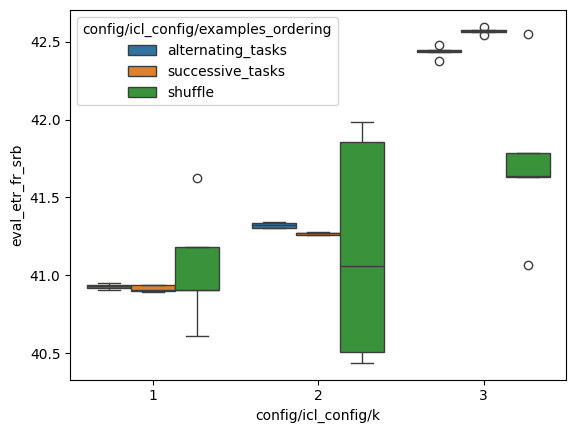

In [277]:
expe = RAGETRFrExpe(model="mistral-7b", method="rag", train_tasks=ALL, step="", expe_dir=ICL_EXPE_DIR)
df = expe.expe_analysis.dataframe()
sns.boxplot(data=df, x="config/icl_config/k", y="eval_etr_fr_srb", hue="config/icl_config/examples_ordering")

In [ ]:
expe = RAGETRFrExpe(model="llama3-8b", method="zero_shot", train_tasks=ETR_FR, step="", expe_dir=ICL_EXPE_DIR)
df = expe.expe_analysis.dataframe()
sns.boxplot(data=df, y="test_etr_fr_srb")

In [ ]:
df["config/icl_config/prompt_template/shot_template"]

In [ ]:
df[config_columns].eq(best_config)

In [ ]:
df = rag_expes[4].expe_analysis.dataframe()

In [ ]:
df = df.map(lambda x: tuple(x) if isinstance(x, list) else x)

In [ ]:
sns.boxplot(data=df, x="config/icl_config/k", y="eval_etr_fr_srb", dodge=True)